<a href="https://colab.research.google.com/github/riccardogabellone/galaxy_recognition_project/blob/master/%5BFINAL%5D_Galaxies_Classification_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.4.2'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'
#!pip3 install 'tensorflow==1.15.0'
#!nvidia-smi

Fri Jan 24 21:30:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Import libraries**

In [2]:
import os
import logging

'''import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn'''
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf
print(tf.__version__, tf.test.gpu_device_name())

import torchvision
from torchvision import transforms
import pandas as pd
from google.colab import files

from torchvision.datasets import VisionDataset

from PIL import Image
import os.path
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


1.15.0 /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 37

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results | original to 256

LR = 1e-4            # The initial Learning Rate was setted to 1e-3
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-4  

NUM_EPOCHS = 5      # initial set to 30
STEP_SIZE = 8        # initial set to 20
GAMMA = 0.1            # initial set to 0.1

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
train_datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)


**Prepare Dataset**

In [5]:
#kaggle competitions download -c galaxy-zoo-the-galaxy-challenge
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]

if not os.path.isdir('./galaxy_recognition_project'):
  !git clone https://github.com/riccardogabellone/galaxy_recognition_project.git

DATA_DIR = 'galaxy_recognition_project'
decision_tree = pd.read_csv("galaxy_recognition_project/training_solutions_rev1/training_solutions_rev1.csv")

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

train_path = 'galaxy_recognition_project/images_training_rev1'
test_path = 'galaxy_recognition_project/images_test_rev1'

def append_ext(fn):
    return fn + ".jpg"

decision_tree["id"] = decision_tree['GalaxyID'].astype(str).apply(append_ext)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=decision_tree,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=decision_tree,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

testdf = pd.read_csv("galaxy_recognition_project/all_zeros_benchmark/all_zeros_benchmark.csv")
testdf["id"] = testdf['GalaxyID'].astype(str).apply(append_ext)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory=test_path,
    x_col = "id",
    y_col = None,
    classes = None,
    class_mode=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(224, 224),
    seed=123,
    shuffle=False
    )

Cloning into 'galaxy_recognition_project'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 141582 (delta 2), reused 7 (delta 1), pack-reused 141571
Receiving objects: 100% (141582/141582), 1.78 GiB | 44.65 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (141561/141561), done.
Found 55421 validated image filenames.
Found 6157 validated image filenames.
Found 79975 validated image filenames.


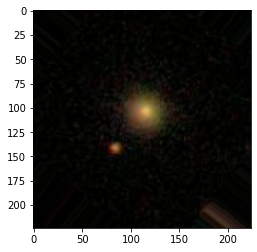

[0.602107   0.378332   0.019561   0.         0.378332   0.
 0.378332   0.         0.378332   0.         0.31476693 0.
 0.06356507 0.10594    0.89406    0.57465453 0.02745247 0.
 0.03350374 0.02673067 0.         0.         0.04570559 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


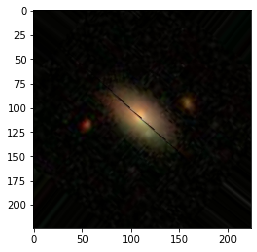

[0.646201   0.321552   0.032248   0.         0.321552   0.
 0.321552   0.         0.321552   0.         0.1441672  0.1773848
 0.         0.5767     0.4233     0.         0.58251401 0.06368699
 0.         0.         0.5086494  0.         0.0680506  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


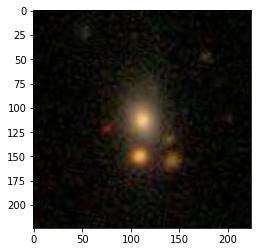

[0.02352941 0.02352941 0.01568628]


In [6]:
plt.imshow(train_generator[42][0][0])
plt.show()
print(train_generator[42][1][0])

plt.imshow(valid_generator[42][0][0])
plt.show()
print(valid_generator[42][1][0])

plt.imshow(test_generator[42][0])
plt.show()
print(test_generator[42][0][0][0])

**Prepare Network**

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def CNN_galaxy():

    model = Sequential()
    model.add(Conv2D(512, (3, 3), input_shape=(224, 224, 3)))
    model.add(Conv2D(256, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling2D())


    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('sigmoid'))

    for layer in model.layers:
      layer.trainable = True

    optimizer = keras.optimizers.Adam(lr=LR, decay=WEIGHT_DECAY)
    model.compile(optimizer, loss='binary_crossentropy', metrics=[root_mean_squared_error])

    return model

#net = CNN_galaxy()
#net.summary()

**Train**

Epoch 1/5
1731/1731 [==============================] - 1839s 1s/step - loss: 0.2605 - root_mean_squared_error: 0.1234 - val_loss: 0.2532 - val_root_mean_squared_error: 0.1142

Epoch 00001: val_loss improved from inf to 0.25320, saving model to drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5
Epoch 2/5
1731/1731 [==============================] - 1841s 1s/step - loss: 0.2598 - root_mean_squared_error: 0.1225 - val_loss: 0.2527 - val_root_mean_squared_error: 0.1136

Epoch 00002: val_loss improved from 0.25320 to 0.25268, saving model to drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5
Epoch 3/5
1731/1731 [==============================] - 1839s 1s/step - loss: 0.2590 - root_mean_squared_error: 0.1217 - val_loss: 0.2525 - val_root_mean_squared_error: 0.1130

Epoch 00003: val_loss improved from 0.25268 to 0.25246, saving model to drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5
Epoch 4/5
1731/1731 [==============================] - 1839s 1s/step - loss: 0.2587 - root_m

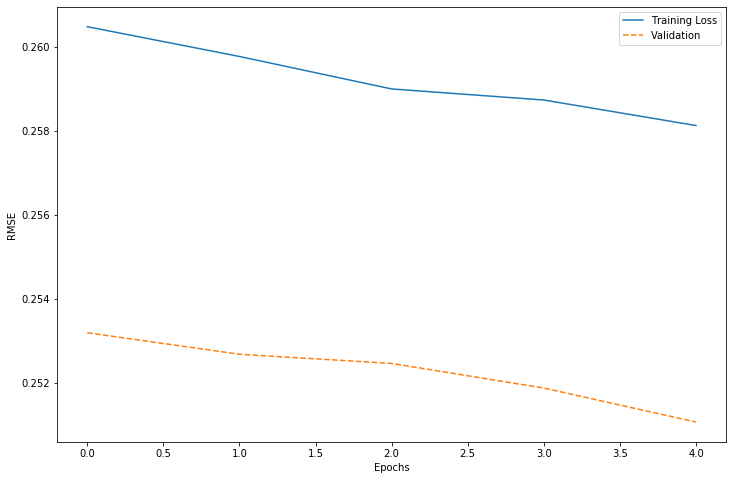

'\n!ls galaxy_recognition_project/checkpoints\n#!cp galaxy_recognition_project/checkpoints/weights.hdf5 drive/My\\ Drive/Colab\\ Notebooks/checkpoint_galaxies.hdf5\n!ls drive/My\\ Drive/Colab\\ Notebooks/checkpoint_galaxies.hdf5\n%cd galaxy_recognition_project\n!pwd'

In [10]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

path_model = 'drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5'
checkpointer = ModelCheckpoint(filepath=path_model, verbose=2, save_best_only=True)

STEP_TRAIN = train_generator.n // train_generator.batch_size
STEP_VALID = valid_generator.n // valid_generator.batch_size
# training the model
hist = net.fit_generator(
    train_generator,
    steps_per_epoch= STEP_TRAIN,
    validation_data=valid_generator,
    validation_steps= STEP_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[history, checkpointer, early_stopping])

plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

'''
!ls galaxy_recognition_project/checkpoints
#!cp galaxy_recognition_project/checkpoints/weights.hdf5 drive/My\ Drive/Colab\ Notebooks/checkpoint_galaxies.hdf5
!ls drive/My\ Drive/Colab\ Notebooks/checkpoint_galaxies.hdf5
%cd galaxy_recognition_project
!pwd'''

**Test**

In [0]:
#net = CNN_galaxy()
net = load_model('drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error})
#net.summary()
test_generator.reset()

predictions = net.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)
print(predictions)

def get_id(fname):
    return fname.replace(".jpg", "").split("/")[0]

header = open('galaxy_recognition_project/all_zeros_benchmark/all_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")
!cp Output.csv drive/My\ Drive/Colab\ Notebooks/predictions.csv       

**Label predictions**

In [1]:
preds = pd.read_csv("drive/My Drive/Colab Notebooks/predictions.csv")
preds["Label"] = preds['GalaxyID'].astype(str)

def create_label(answers):
    if answers[0] == 'Class1.1':
        label = 'Smooth'
        if answers[6] == 'Class7.1':
            label += ', completely round'
        if answers[6] == 'Class7.2':
            label += ', almost round'
        if answers[5] == 'Class6.1':
            if answers[7] == 'Class8.1':
                label += ', ring'
                return label
            if answers[7] == 'Class8.2':
                label += ', lens'
                return label
            if answers[7] == 'Class8.3':
                label += ', disturbed'
                return label
            if answers[7] == 'Class8.4':
                label += ', irregular'
                return label
            if answers[7] == 'Class8.5':
                label += ', odd feature'
                return label
            if answers[7] == 'Class8.6':
                label += ', merger'
                return label
            if answers[7] == 'Class8.7':
                label += ', dust lane'
                return label
        if answers[5] == 'Class6.2':
            return label
    if answers[0] == 'Class1.2':
        label = 'Disc'
        if answers[1] == 'Class2.1':
            if answers[8] == 'Class9.1':
                label += ', rounded'
            if answers[8] == 'Class9.2':
                label += ', boxy'
            if answers[8] == 'Class9.3':
                label += ', no bulge'
            if answers[5] == 'Class6.1':
                if answers[7] == 'Class8.1':
                    label += ', ring'
                    return label
                if answers[7] == 'Class8.2':
                    label += ', lens'
                    return label
                if answers[7] == 'Class8.3':
                    label += ', disturbed'
                    return label
                if answers[7] == 'Class8.4':
                    label += ', irregular'
                    return label
                if answers[7] == 'Class8.5':
                    label += ', odd feature'
                    return label
                if answers[7] == 'Class8.6':
                    label += ', merger'
                    return label
                if answers[7] == 'Class8.7':
                    label += ', dust lane'
                    return label
            if answers[5] == 'Class6.2':
                return label
        if answers[1] == 'Class2.2':
            if answers[3] == 'Class4.1':
                if answers[9] == 'Class10.1':
                    label += ', tight arms'
                if answers[9] == 'Class10.2':
                    label += ', medium arms'
                if answers[9] == 'Class10.3':
                    label += ', loose arms'
                if answers[10] == 'Class11.1':
                    label += ', 1 arm'
                if answers[10] == 'Class11.2':
                    label += ', 2 arms'
                if answers[10] == 'Class11.3':
                    label += ', 3 arms'
                if answers[10] == 'Class11.4':
                    label += ', 4 arms'
                if answers[10] == 'Class11.5':
                    label += ', more than 4 arms'
                if answers[10] == 'Class11.6':
                    label += ', cannot count arms'
                if answers[4] == 'Class5.1':
                    label += ', no bulge'
                if answers[4] == 'Class5.2':
                    label += ', little bulge'
                if answers[4] == 'Class5.3':
                    label += ', obvious bulge'
                if answers[4] == 'Class5.4':
                    label += ', dominant bulge'
                if answers[5] == 'Class6.1':
                    if answers[7] == 'Class8.1':
                        label += ', ring'
                        return label
                    if answers[7] == 'Class8.2':
                        label += ', lens'
                        return label
                    if answers[7] == 'Class8.3':
                        label += ', disturbed'
                        return label
                    if answers[7] == 'Class8.4':
                        label += ', irregular'
                        return label
                    if answers[7] == 'Class8.5':
                        label += ', odd feature'
                        return label
                    if answers[7] == 'Class8.6':
                        label += ', merger'
                        return label
                    if answers[7] == 'Class8.7':
                        label += ', dust lane'
                        return label
                if answers[5] == 'Class6.2':
                    return label
            if answers[3] == 'Class4.2':
                if answers[4] == 'Class5.1':
                    label += ', no bulge'
                if answers[4] == 'Class5.2':
                    label += ', little bulge'
                if answers[4] == 'Class5.3':
                    label += ', obvious bulge'
                if answers[4] == 'Class5.4':
                    label += ', dominant bulge'
                if answers[5] == 'Class6.1':
                    if answers[7] == 'Class8.1':
                        label += ', ring'
                        return label
                    if answers[7] == 'Class8.2':
                        label += ', lens'
                        return label
                    if answers[7] == 'Class8.3':
                        label += ', disturbed'
                        return label
                    if answers[7] == 'Class8.4':
                        label += ', irregular'
                        return label
                    if answers[7] == 'Class8.5':
                        label += ', odd feature'
                        return label
                    if answers[7] == 'Class8.6':
                        label += ', merger'
                        return label
                    if answers[7] == 'Class8.7':
                        label += ', dust lane'
                        return label
                if answers[5] == 'Class6.2':
                    return label
    if answers[0] == 'Class1.3':
        label = 'Star or artefact'
        return label

for i in range(len(preds)):
    cur = []
    choose = 0.0
    for c in classes:
        for j in range(11):
            if(c.split('.')[0] == 'Class'+str(j+1)):
                #print('Q'+str(j+1))
                if(c.split('.')[1] == '1'):
                    if(c.split('.')[0] != 'Class1'):
                        cur.append(cur_c)
                    choose = 0.0
                if(choose < preds[c][i]):
                    choose = preds[c][i]
                    cur_c = c
                #print(preds[c][i])
    cur.append(cur_c) #append last one (11)
    #print(cur)
    #function that return the label with cur as input
    preds["Label"][i] = create_label(cur)

print(preds)

NameError: ignored